In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import shap


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

c:\Users\sbhurtyal\Desktop\Projects\Lit\AVP\.avp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Data/Australian Vehicle Prices.csv')
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 16734
Number of columns: 19


In [3]:
display(df.head(2))

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990


#  Data Cleaning

In [4]:
#Focus is on Used Cars. Let's keep only the rows where the 'New/Used' column is 'USED'
df = df[df['UsedOrNew'] == 'USED']
#Drop the 'UsedOrNew' column
df.drop('UsedOrNew', axis=1, inplace=True)
#Rename Kilomtres to Kilometers
df.rename(columns={'Kilometres': 'Kilometers'}, inplace=True)
#Drop Title
df.drop('Title', axis=1, inplace=True)

In [5]:
#Print number of rows where at least one element is missing
print('Number of rows with missing values:', df.isnull().any(axis=1).sum(), 'out of', df.shape[0], 'rows. This is', round(df.isnull().any(axis=1).sum()/df.shape[0]*100, 2), '% of the data.')

Number of rows with missing values: 1477 out of 14994 rows. This is 9.85 % of the data.


In [6]:
#Print number of missing values in each column
pd.concat([df.nunique(), df[df.isnull().any(axis=1)].nunique()], axis=1, keys=['Unique Values (In Original Dataset)', 'Unique Values (In Missing Dataset)'])

,Unique Values (In Original Dataset),Unique Values (In Missing Dataset)
Brand,70,53
Year,45,40
Model,724,281
Car/Suv,410,397
Transmission,3,3
Engine,91,11
DriveType,5,5
FuelType,9,8
FuelConsumption,153,2
Kilometers,14003,1434


In [7]:
print('Missing values are failry distributed and are not conentrated to specific values in columns.  It is safe to remove rows with missing values. This still leaves us with ', df.dropna().shape[0], 'rows of data.')

Missing values are failry distributed and are not conentrated to specific values in columns.  It is safe to remove rows with missing values. This still leaves us with  13517 rows of data.


In [8]:
df = df.dropna()
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())

Number of rows with missing values: 0


In [9]:
display(df.head())

,Brand,Year,Model,Car/Suv,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometers,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
1,MG,2022.0,MG3,Hatchback,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990
6,Land,2017.0,Rover,SUV,Automatic,"4 cyl, 2 L",AWD,Diesel,5.1 L / 100 km,67662,White / Black,"Blacktown, NSW",4 cyl,SUV,2 Doors,4 Seats,62280


In [10]:
#Cleaning Data
#Engine column is in 4 cyl, 2.2 L format. There already is CylindersinEngine column. We only need the engine size
df['EngineSize'] = df['Engine'].str.split(', ').str[1].str.replace(' L', '')
#Remove ' cyl' from CylindersinEngine column
df['CylindersinEngine'] = df['CylindersinEngine'].str.replace(' cyl', '')
#FuelConsumption is in 8.7 L/100 km format. We only need the ratio
df['FuelConsumption(L per 100km)'] = df['FuelConsumption'].str.split(' ').str[0]
#Exterior colour
df['ExteriorColour'] = df['ColourExtInt'].str.split(' / ').str[0].replace('-', None)
#Remove ' Doors' from Doors column
df['Doors'] = df['Doors'].str.replace(' Doors', '')
#Remove ' Seats' from Seats column
df['Seats'] = df['Seats'].str.replace(' Seats', '')
#Location is in City, State format. We only need the State
df['Location'] = df['Location'].str.split(', ').str[1]
#Drop columns
df.drop(columns=['Engine', 'FuelConsumption', 'ColourExtInt'], inplace=True)
#If values in Price can't be converted to Int, drop the row
df = df[df['Price'].str.isnumeric()]
#Replace '-' with None in all columns
df.replace('-', None, inplace=True)
df.head()

,Brand,Year,Model,Car/Suv,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022.0,MG3,Hatchback,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022.0,430I,Coupe,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2,6.6,Grey
3,Mercedes-Benz,2011.0,E500,Coupe,Automatic,Rear,Premium,136517,NSW,8,Coupe,2,4,32990,5.5,11,White
4,Renault,2022.0,Arkana,SUV,Automatic,Front,Unleaded,1035,NSW,4,SUV,4,5,34990,1.3,6,Grey
6,Land,2017.0,Rover,SUV,Automatic,AWD,Diesel,67662,NSW,4,SUV,2,4,62280,2,5.1,White


In [11]:
#Drop rows with missing values
df = df.dropna()
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 13072


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13072 entries, 1 to 16733
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Brand                         13072 non-null  object 
 1   Year                          13072 non-null  float64
 2   Model                         13072 non-null  object 
 3   Car/Suv                       13072 non-null  object 
 4   Transmission                  13072 non-null  object 
 5   DriveType                     13072 non-null  object 
 6   FuelType                      13072 non-null  object 
 7   Kilometers                    13072 non-null  object 
 8   Location                      13072 non-null  object 
 9   CylindersinEngine             13072 non-null  object 
 10  BodyType                      13072 non-null  object 
 11  Doors                         13072 non-null  object 
 12  Seats                         13072 non-null  object 
 13  Price 

In [13]:
#Change data types
df['Year'] = df['Year'].astype(int)
df['Kilometers'] = df['Kilometers'].str.replace(',', '').astype(int)
df['CylindersinEngine'] = df['CylindersinEngine'].astype(int)
df['Doors'] = df['Doors'].astype(int)
df['Seats'] = df['Seats'].astype(int)
df['Price'] = df['Price'].astype(int)
df['EngineSize'] = df['EngineSize'].astype(float)  
df['FuelConsumption(L per 100km)'] = df['FuelConsumption(L per 100km)'].astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13072 entries, 1 to 16733
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Brand                         13072 non-null  object 
 1   Year                          13072 non-null  int64  
 2   Model                         13072 non-null  object 
 3   Car/Suv                       13072 non-null  object 
 4   Transmission                  13072 non-null  object 
 5   DriveType                     13072 non-null  object 
 6   FuelType                      13072 non-null  object 
 7   Kilometers                    13072 non-null  int64  
 8   Location                      13072 non-null  object 
 9   CylindersinEngine             13072 non-null  int64  
 10  BodyType                      13072 non-null  object 
 11  Doors                         13072 non-null  int64  
 12  Seats                         13072 non-null  int64  
 13  Price 

In [15]:
display(df.head())

,Brand,Year,Model,Car/Suv,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022,MG3,Hatchback,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022,430I,Coupe,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2.0,6.6,Grey
3,Mercedes-Benz,2011,E500,Coupe,Automatic,Rear,Premium,136517,NSW,8,Coupe,2,4,32990,5.5,11.0,White
4,Renault,2022,Arkana,SUV,Automatic,Front,Unleaded,1035,NSW,4,SUV,4,5,34990,1.3,6.0,Grey
6,Land,2017,Rover,SUV,Automatic,AWD,Diesel,67662,NSW,4,SUV,2,4,62280,2.0,5.1,White


In [16]:
display(df.describe())

,Year,Kilometers,CylindersinEngine,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km)
count,13072.000000,13072.000000,13072.000000,13072.000000,13072.000000,13072.000000,13072.000000,13072.000000
mean,2015.766447,106656.681380,4.473608,4.015453,5.116050,33292.387775,2.436483,7.803366
std,4.743598,75488.400606,1.065698,0.685426,1.108005,27527.866247,0.874985,2.150699
min,1978.000000,1.000000,2.000000,2.000000,2.000000,88.000000,0.700000,0.000000
25%,2013.000000,50429.750000,4.000000,4.000000,5.000000,17990.000000,2.000000,6.600000
50%,2017.000000,90890.500000,4.000000,4.000000,5.000000,27970.000000,2.200000,7.600000
75%,2019.000000,151124.750000,4.000000,4.000000,5.000000,39990.000000,2.800000,8.800000
max,2023.000000,526162.000000,12.000000,5.000000,22.000000,649880.000000,7.300000,27.000000


In [17]:
#Zero Fuel Consumption is not possible. Remove rows with 0 Fuel Consumption
df = df[df['FuelConsumption(L per 100km)'] != 0]
#Let's remove Year below 1990 as they are considered classic cars. It is better to analyze them separately if enough data is available.
df = df[df['Year'] >= 1990]
#Let's keep the cars with price above $1000
df = df[df['Price'] >= 1000]
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 12922


In [18]:
#Let's analyze the data where kilometers are less than 25, the car is used and the year is less than 2022
display(df[(df['Kilometers'] < 25) & (df['Year'] < 2022)])
print('It is highly unlikely that a car has less than 25 kilometers on it and bought before 2022 and is used. Let\'s remove these rows.')
df = df[~((df['Kilometers'] < 25) & (df['Year'] < 2022))]
print('Number of rows remaining:', df.shape[0])

,Brand,Year,Model,Car/Suv,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
12618,Holden,2016,Captiva,SUV,Automatic,Front,Unleaded,1,NT,4,SUV,4,7,15990,2.4,9.0,Blue
13296,Mitsubishi,2021,Eclipse,SUV,Automatic,Front,Unleaded,1,SA,4,SUV,4,5,34990,1.5,7.3,Silver


It is highly unlikely that a car has less than 25 kilometers on it and bought before 2022 and is used. Let's remove these rows.
Number of rows remaining: 12920


In [19]:
df.nunique()

Brand                              60
Year                               33
Model                             591
Car/Suv                            10
Transmission                        2
DriveType                           5
FuelType                            5
Kilometers                      12241
Location                            8
CylindersinEngine                   8
BodyType                           10
Doors                               4
Seats                              10
Price                            2733
EngineSize                         56
FuelConsumption(L per 100km)      149
ExteriorColour                     18
dtype: int64

In [20]:
#Let's drop Model and Car/Suv. They have too many unique values. Also, these values can be inferred from other columns such as DriveType, clyindersinEngine, etc.
df.drop(columns=['Model', 'Car/Suv'], inplace=True)

In [21]:
display(df.head())

,Brand,Year,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2.0,6.6,Grey
3,Mercedes-Benz,2011,Automatic,Rear,Premium,136517,NSW,8,Coupe,2,4,32990,5.5,11.0,White
4,Renault,2022,Automatic,Front,Unleaded,1035,NSW,4,SUV,4,5,34990,1.3,6.0,Grey
6,Land,2017,Automatic,AWD,Diesel,67662,NSW,4,SUV,2,4,62280,2.0,5.1,White


# Exploratory Analysis

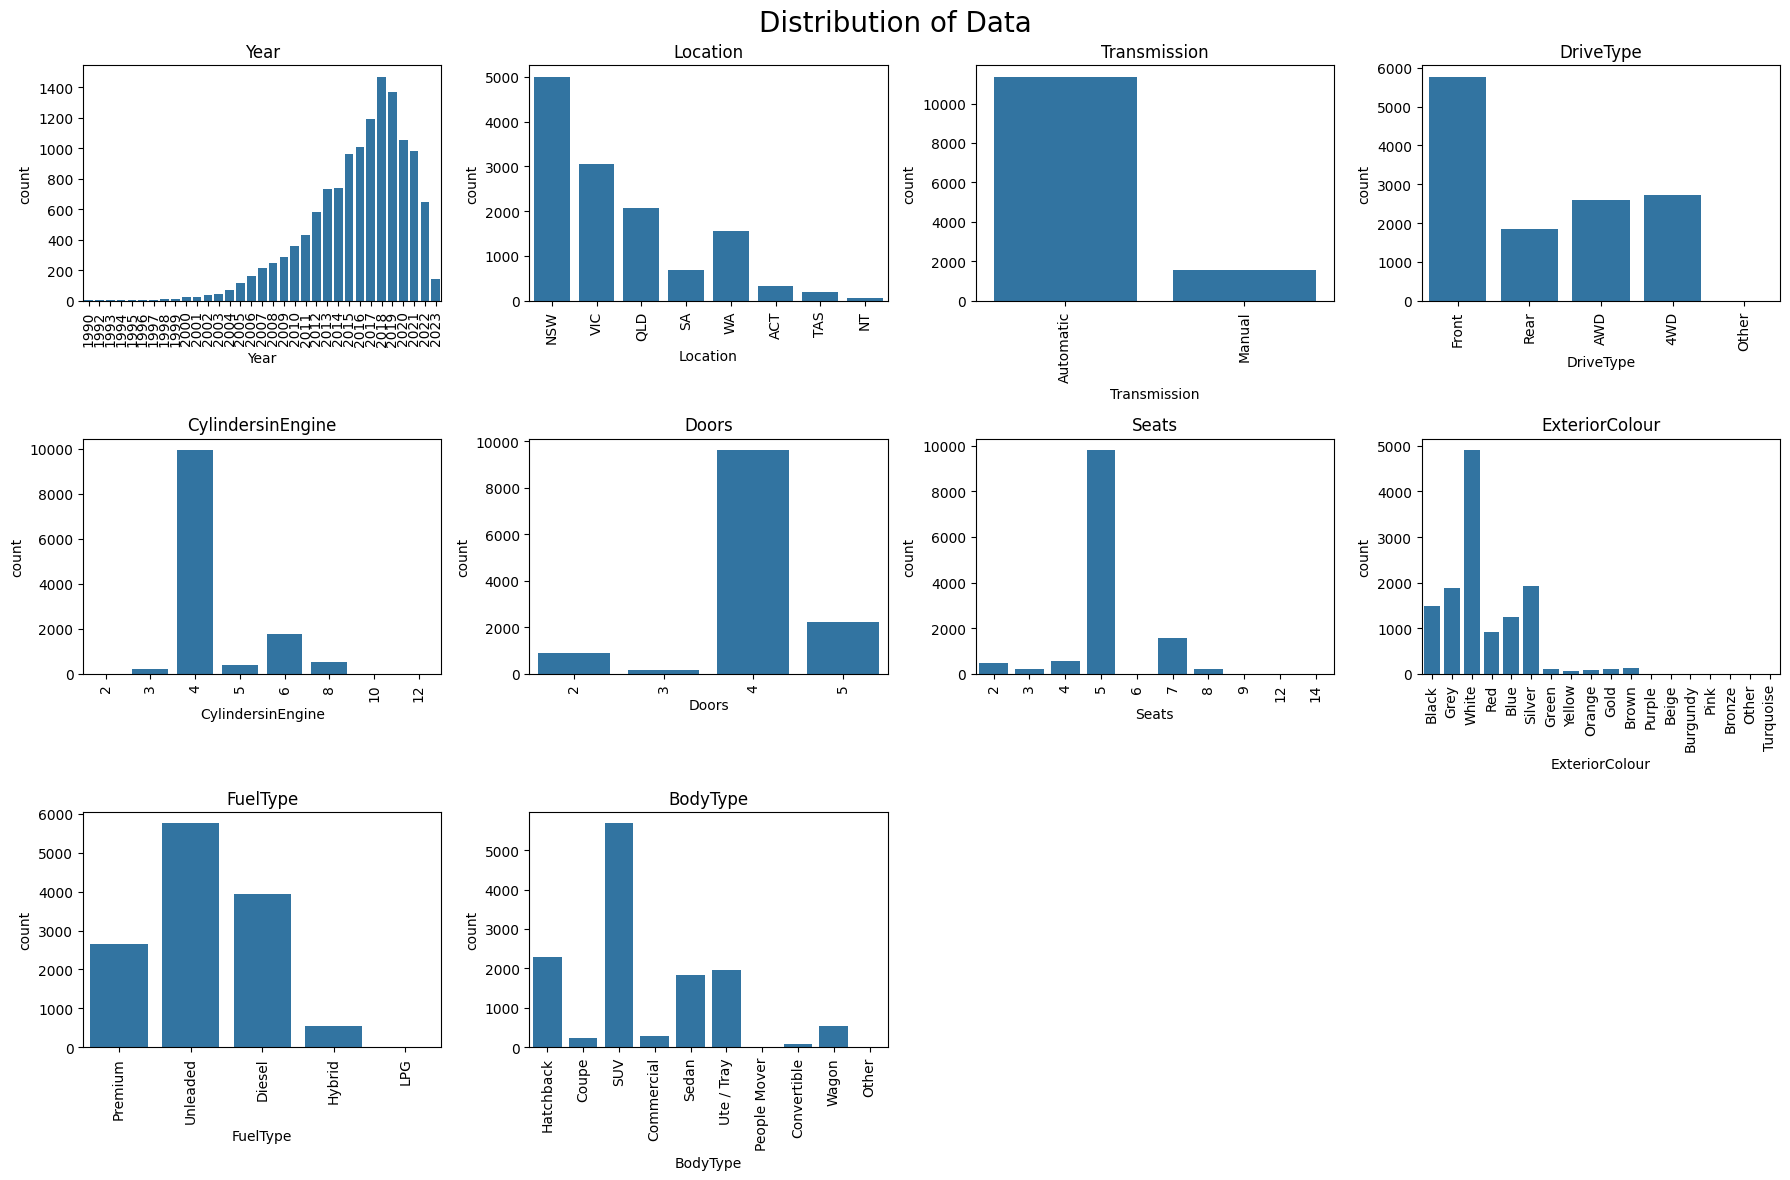

In [22]:
#Let's do some exploratory data analysis
#Plot of records by all columns except Price and Kilometers and FuelConsumption
columns = ['Year', 'Location', 'Transmission', 'DriveType', 'CylindersinEngine', 'Doors', 'Seats', 'ExteriorColour', 'FuelType', 'BodyType']
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle('Distribution of Data', fontsize=20)

for ax, col in zip(axes.flatten(), columns):
    plot = sns.countplot(ax=ax, data=df, x=col)
    ax.set_title(col)  # Optional: add a title for each subplot
    for label in ax.get_xticklabels():
        label.set_rotation(90)

#Remove empty subplot
fig.delaxes(axes.flatten()[11])
fig.delaxes(axes.flatten()[10])

plt.tight_layout()
plt.show()

In [23]:
#Drive type can't be Other. Let's remove those rows
df = df[df['DriveType'] != 'Other']
#Do the same for ExteriorColour
df = df[df['ExteriorColour'] != 'Other']
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 12917


In [24]:
df.head(2)

,Brand,Year,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,MG,2022,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,Black
2,BMW,2022,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2.0,6.6,Grey


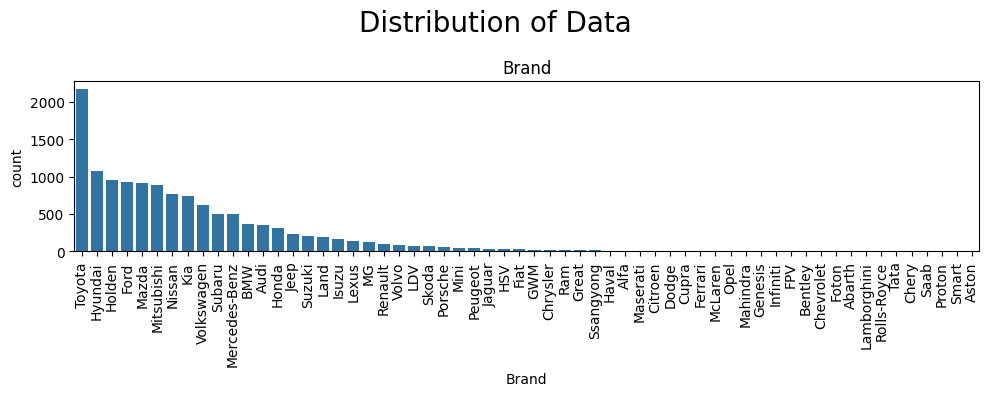

In [25]:
#Plot count by Brand and BodyType
fig, axes = plt.subplots(figsize=(10, 4))
fig.suptitle('Distribution of Data', fontsize=20)

# Plot count by Brand
plot = sns.countplot(data=df, x='Brand', order=df['Brand'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Brand')
plt.tight_layout()
plt.show()

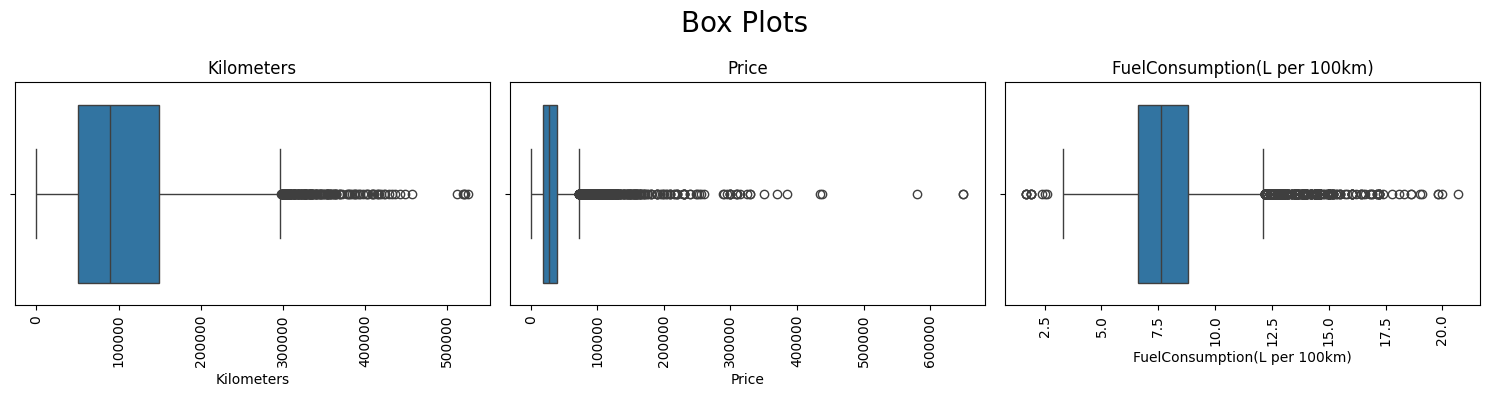

In [26]:
#Plot box plot for Year, Kilometers, Price, FuelConsumption, and Price
cols = ['Kilometers', 'Price', 'FuelConsumption(L per 100km)']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Box Plots', fontsize=20)

for ax, col in zip(axes.flatten(), cols):
    plot = sns.boxplot(ax=ax, data=df, x=col)
    ax.set_title(col)  # Optional: add a title for each subplot
    #Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

In [27]:
#Remove outliers based on IQR for Kilometers, Price, and FuelConsumption column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

df_model = remove_outliers(df, 'Kilometers')
df_model = remove_outliers(df, 'Price')
df_model = remove_outliers(df, 'FuelConsumption(L per 100km)')
print('Number of rows remaining:', df.shape[0])

Number of rows remaining: 12917


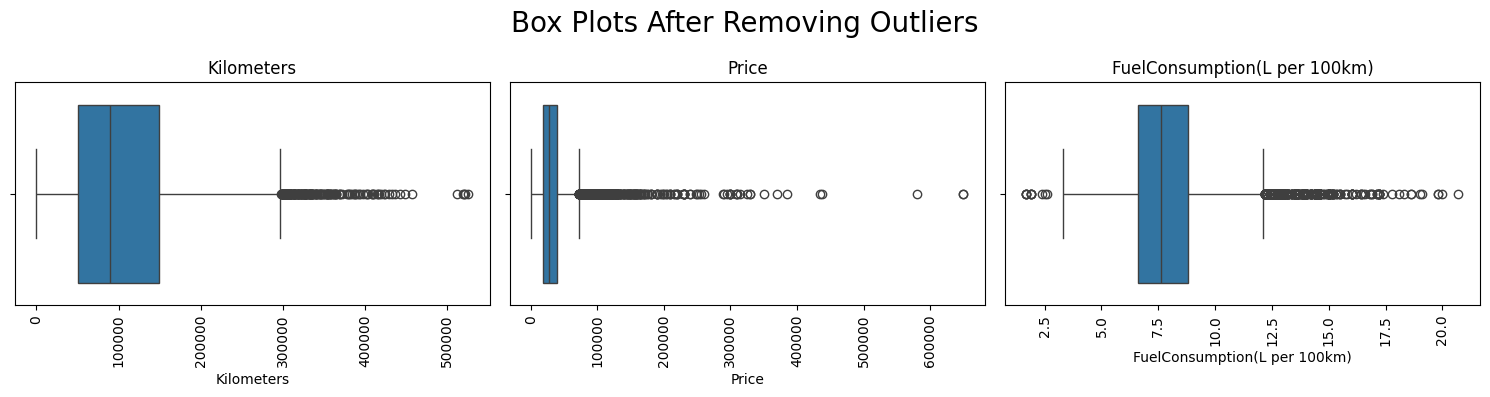

In [28]:
#Plot box plot for Year, Kilometers, Price, FuelConsumption, and Price
cols = ['Kilometers', 'Price', 'FuelConsumption(L per 100km)']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Box Plots After Removing Outliers', fontsize=20)

for ax, col in zip(axes.flatten(), cols):
    plot = sns.boxplot(ax=ax, data=df, x=col)
    ax.set_title(col)  # Optional: add a title for each subplot
    #Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()
plt.show()

# Feature Engineering

In [29]:
df_model = df.copy()
#Target encoding for Brand and ExteriorColour using TargetEncoder with smoothing to avoid overfitting
encoder = TargetEncoder(smoothing=0.5)
df_model['Brand'] = encoder.fit_transform(df_model['Brand'], df_model['Price'])
df_model['ExteriorColour'] = encoder.fit_transform(df_model['ExteriorColour'], df_model['Price'])

In [30]:
df_model.head()

,Brand,Year,Transmission,DriveType,FuelType,Kilometers,Location,CylindersinEngine,BodyType,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour
1,25196.268293,2022,Automatic,Front,Premium,16,NSW,4,Hatchback,5,5,19990,1.5,6.7,37812.966398
2,42878.005495,2022,Automatic,Rear,Premium,8472,NSW,4,Coupe,2,4,108988,2.0,6.6,35541.896809
3,53966.413655,2011,Automatic,Rear,Premium,136517,NSW,8,Coupe,2,4,32990,5.5,11.0,34692.937080
4,24471.718447,2022,Automatic,Front,Unleaded,1035,NSW,4,SUV,4,5,34990,1.3,6.0,35541.896809
6,69544.373684,2017,Automatic,AWD,Diesel,67662,NSW,4,SUV,2,4,62280,2.0,5.1,34692.937080


In [31]:
#One Hot Encoding for Transmission, DriveType, FuelType, Location, CylindersinEngine, BodyType
df_model = pd.get_dummies(df_model, columns=['Transmission', 'DriveType', 'FuelType', 'Location', 'BodyType'], dtype=int, drop_first=True)

In [32]:
#Convert Year column to Age
df_model['Age'] = 2023 - df_model['Year']
#Drop Year column
df_model.drop('Year', axis=1, inplace=True)

In [33]:
df_model.head()

,Brand,Kilometers,CylindersinEngine,Doors,Seats,Price,EngineSize,FuelConsumption(L per 100km),ExteriorColour,Transmission_Manual,DriveType_AWD,DriveType_Front,DriveType_Rear,FuelType_Hybrid,FuelType_LPG,FuelType_Premium,FuelType_Unleaded,Location_NSW,Location_NT,Location_QLD,Location_SA,Location_TAS,Location_VIC,Location_WA,BodyType_Convertible,BodyType_Coupe,BodyType_Hatchback,BodyType_Other,BodyType_People Mover,BodyType_SUV,BodyType_Sedan,BodyType_Ute / Tray,BodyType_Wagon,Age
1,25196.268293,16,4,5,5,19990,1.5,6.7,37812.966398,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,42878.005495,8472,4,2,4,108988,2.0,6.6,35541.896809,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,53966.413655,136517,8,2,4,32990,5.5,11.0,34692.937080,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,12
4,24471.718447,1035,4,4,5,34990,1.3,6.0,35541.896809,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,69544.373684,67662,4,2,4,62280,2.0,5.1,34692.937080,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6


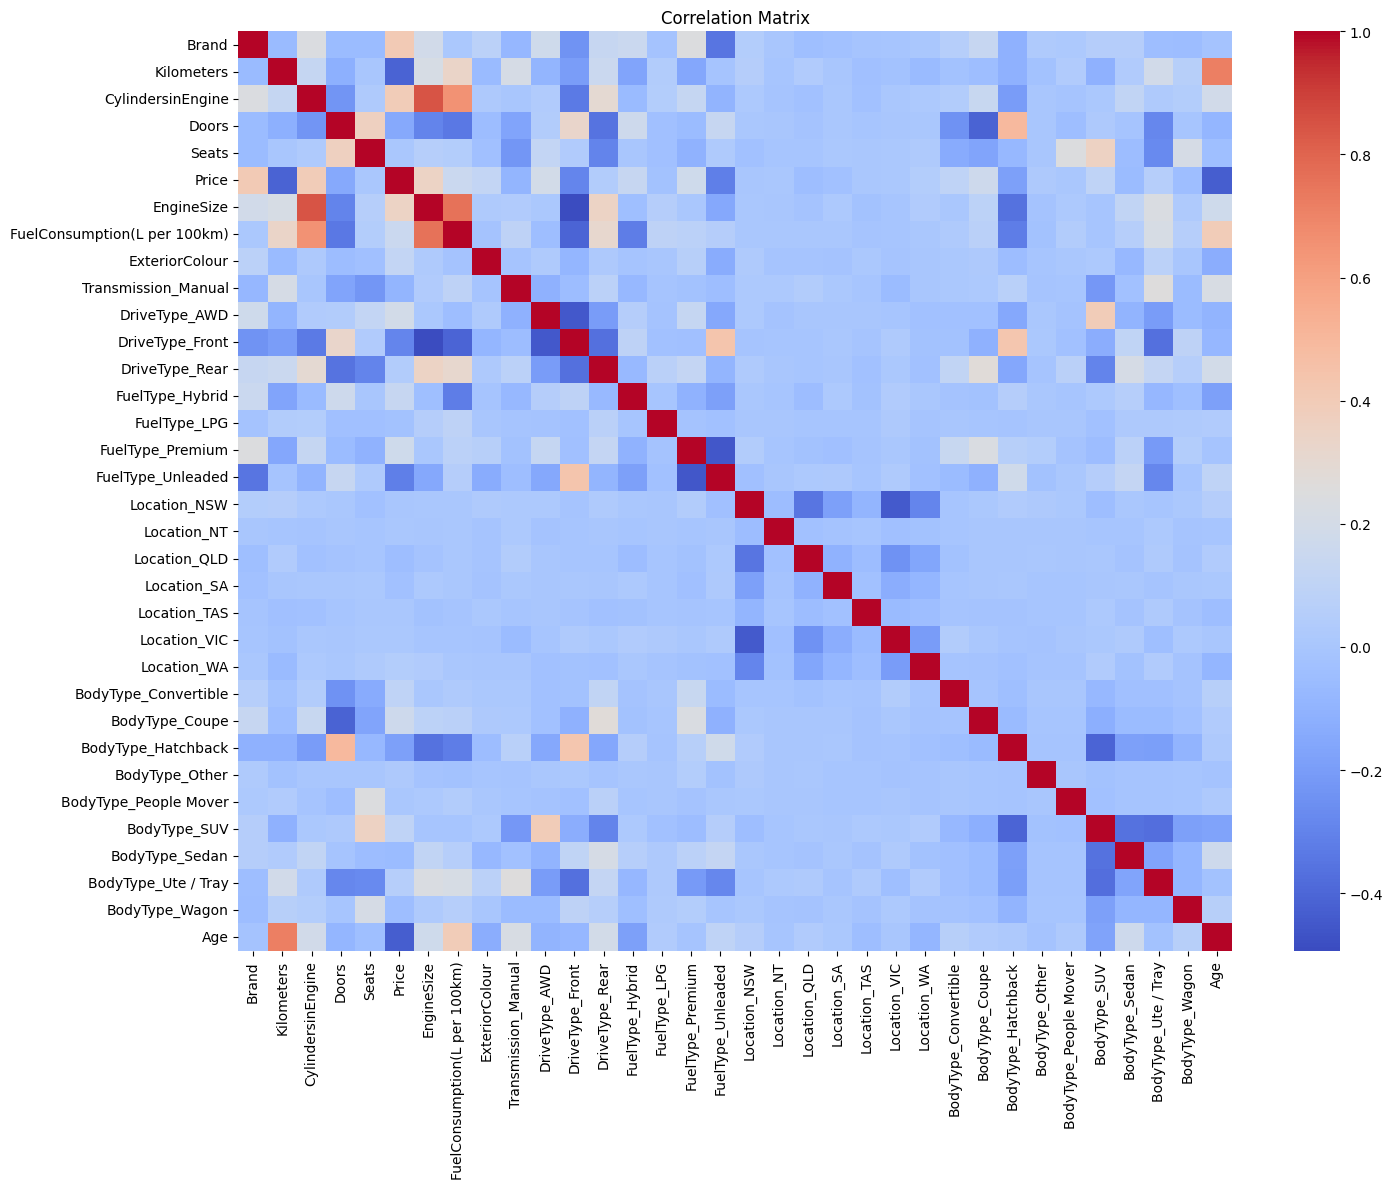

In [34]:
#Correlation Matrix
plt.figure(figsize=(15, 12))
sns.heatmap(df_model.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [35]:
print('Year and Kilometers are strongly correlated. This is expected as older cars have more kilometers on them. However let\'s keep both since these two are important factors in deciding the price.')
print('CylindersinEngine, EngineSize, and FuelConsumption(L per 100km) are also correlated. We will keep CylindersinEngine and FuelConsumption.')
print('Drop Droors and Seats')
df_model.drop(columns=['EngineSize', 'Doors', 'Seats', 'CylindersinEngine'], inplace=True)

Year and Kilometers are strongly correlated. This is expected as older cars have more kilometers on them. However let's keep both since these two are important factors in deciding the price.
CylindersinEngine, EngineSize, and FuelConsumption(L per 100km) are also correlated. We will keep CylindersinEngine and FuelConsumption.
Drop Droors and Seats


### Splitting the data into train and test

In [36]:
# Split the data into train and test sets
X = df_model.drop('Price', axis=1)
y = df_model['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (10333, 29)
X_test shape: (2584, 29)


In [37]:
df_model.shape

(12917, 30)

In [38]:
#Replace space and braces with underscore in column names
df_model.columns = df_model.columns.str.replace(' ', '_')
df_model.columns = df_model.columns.str.replace('(', '')
df_model.columns = df_model.columns.str.replace(')', '')
df_model.columns = df_model.columns.str.replace('/', '_')

In [39]:
display(df_model.head())

,Brand,Kilometers,Price,FuelConsumptionL_per_100km,ExteriorColour,Transmission_Manual,DriveType_AWD,DriveType_Front,DriveType_Rear,FuelType_Hybrid,FuelType_LPG,FuelType_Premium,FuelType_Unleaded,Location_NSW,Location_NT,Location_QLD,Location_SA,Location_TAS,Location_VIC,Location_WA,BodyType_Convertible,BodyType_Coupe,BodyType_Hatchback,BodyType_Other,BodyType_People_Mover,BodyType_SUV,BodyType_Sedan,BodyType_Ute___Tray,BodyType_Wagon,Age
1,25196.268293,16,19990,6.7,37812.966398,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,42878.005495,8472,108988,6.6,35541.896809,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,53966.413655,136517,32990,11.0,34692.937080,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,12
4,24471.718447,1035,34990,6.0,35541.896809,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
6,69544.373684,67662,62280,5.1,34692.937080,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6


# Models

## Regression

In [40]:
# OLS
df_model_ols = df_model.copy()
dependent_variable = 'Price'
independent_variables = df_model_ols.drop(dependent_variable, axis=1).columns
formula = dependent_variable + ' ~ ' + ' + '.join(independent_variables)
ols_model = smf.ols(formula=formula, data=df_model_ols).fit()

print('Before we interpret the results, let\'s check the assumptions of OLS.')

Before we interpret the results, let's check the assumptions of OLS.


### Tests 

In [41]:
#Check for independent errors using Durbin-Watson test
durbin_watson(ols_model.resid)
print('Durbin-Watson test statistic:', durbin_watson(ols_model.resid), '. It is close to 2, which means there is no autocorrelation in the residuals.')

Durbin-Watson test statistic: 1.9871757436262525 . It is close to 2, which means there is no autocorrelation in the residuals.


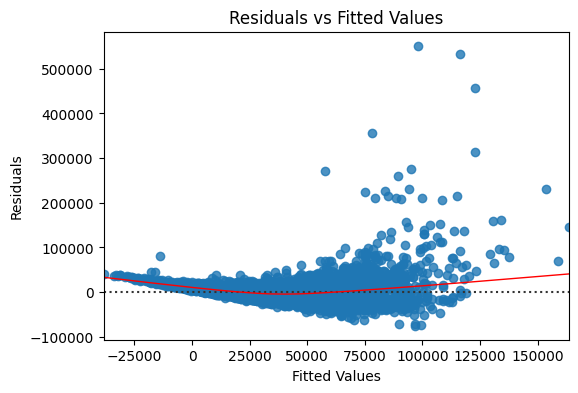

The residuals are not randomly distributed around 0. This means that the model is not linear.


In [42]:
#Check for linearity of the data with residuals vs fitted values plot
plt.figure(figsize=(6, 4))
sns.residplot(x=ols_model.fittedvalues, y=ols_model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

print('The residuals are not randomly distributed around 0. This means that the model is not linear.')

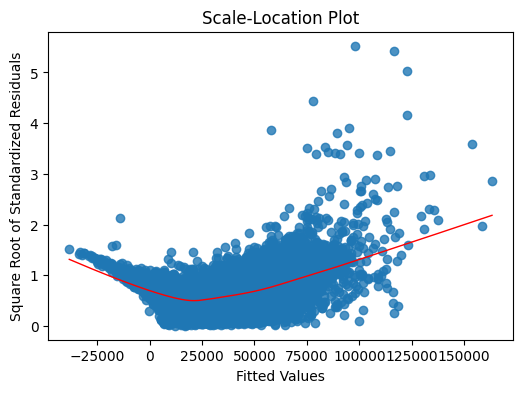

The residuals do not have constant variance.


In [43]:
#Check  if residual errors have constant variance using Scale-Location plot
plt.figure(figsize=(6, 4))
sns.regplot(x=ols_model.fittedvalues, y=np.sqrt(np.abs(ols_model.get_influence().resid_studentized_internal)), lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Square Root of Standardized Residuals')
plt.title('Scale-Location Plot')
plt.show()

print('The residuals do not have constant variance.')

In [44]:
#Check for heteroscedasticity using Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print('Breusch-Pagan test statistic:', bp_test[0])
print('p-value:', bp_test[1])

print('Since the p-value is less than 0.05, we reject the null hypothesis that the variance of the residuals is constant. This means that the model is heteroscedastic.')
print('Let\'s try to fix this by transforming the dependent variable using log transformation.')

Breusch-Pagan test statistic: 695.3020052589317
p-value: 9.466861029856215e-128
Since the p-value is less than 0.05, we reject the null hypothesis that the variance of the residuals is constant. This means that the model is heteroscedastic.
Let's try to fix this by transforming the dependent variable using log transformation.


In [45]:
#Log transformation of dependent variable
df_model_ols['Price'] = np.log(df_model_ols['Price'])
dependent_variable = 'Price'
formula = dependent_variable + ' ~ ' + ' + '.join(independent_variables)
ols_model = smf.ols(formula=formula, data=df_model_ols).fit()

In [46]:
#Check for homoscedasticity using Breusch-Pagan test
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print('Breusch-Pagan test statistic:', bp_test[0])
print('p-value:', bp_test[1])

Breusch-Pagan test statistic: 1535.2089167894048
p-value: 1.687344266560884e-305


In [47]:
print('Transformation did not fix the heteroscedasticity. Therefore we will use machine learning models.')

Transformation did not fix the heteroscedasticity. Therefore we will use machine learning models.


## Decision Tree

In [48]:
#Decision Tree
dt = DecisionTreeRegressor(random_state=42)
hp = {'max_depth': range(1, 10), 
      'splitter': ['best', 'random'],
      'min_samples_split': range(2, 5),
      }
gs = GridSearchCV(dt, hp, cv=3, n_jobs=4, verbose=0, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print('Best parameters:', gs.best_params_)
dt = gs.best_estimator_
y_pred = dt.predict(X_test)

Best parameters: {'max_depth': 9, 'min_samples_split': 2, 'splitter': 'best'}


## Random Forest

In [49]:
#Random Forest
rf = RandomForestRegressor(random_state=42)
hp = {'n_estimators': [100, 200, 300], #Number of decision trees
      'max_depth': range(1, 10), #Maximum possible depth of each decision tree
      'min_samples_split': range(2, 5), #Minimum number of samples required to split an internal node
      }
gs = GridSearchCV(rf, hp, cv=3, n_jobs=4, verbose=0, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print('Best parameters:', gs.best_params_)
rf = gs.best_estimator_
y_pred = rf.predict(X_test)


Best parameters: {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 300}


## Gradient Boosting

In [50]:
#Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
hp = {'n_estimators': [100, 200, 300], 
      'max_depth': range(1, 10), 
      'min_samples_split': range(2, 5), 
      }
gs = GridSearchCV(gb, hp, cv=3, n_jobs=4, verbose=0, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print('Best parameters:', gs.best_params_)
gb = gs.best_estimator_
y_pred = gb.predict(X_test)

Best parameters: {'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 300}


## XGBoost

In [51]:
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
hp = {'n_estimators': [100, 200, 300],
      'max_depth': range(1, 10),
      'min_child_weight': [3, 5, 7],
      'learning_rate': [0.01, 0.05, 0.1],
      }
gs = GridSearchCV(xgb, hp, cv=3, n_jobs=4, verbose=0, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)
print('Best parameters:', gs.best_params_)
xgb = gs.best_estimator_
y_pred = xgb.predict(X_test)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}


# Model Evaluation

In [52]:
def metrics(y_test, model, name):
    y_pred = model.predict(X_test)
    # mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'Root Mean Squared Error': rmse, 'Mean Absolute Percentage Error': mape, 'R2 Score': r2}

models = [dt, rf, gb, xgb]
model_name = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']
results = []
for model, name in zip(models, model_name):
    results.append(metrics(y_test, model, name))

results = pd.DataFrame(results)
#Format the values
#Non scientific notation with comma
results['Root Mean Squared Error'] = results['Root Mean Squared Error'].apply(lambda x: "{:,.0f}".format(x))
results['Mean Absolute Percentage Error'] = results['Mean Absolute Percentage Error'].apply(lambda x: round(x, 2))
results['R2 Score'] = results['R2 Score'].apply(lambda x: round(x, 2))

print(tabulate(results, headers='keys', tablefmt='psql'))

+----+-------------------+---------------------------+----------------------------------+------------+
|    | Model             | Root Mean Squared Error   |   Mean Absolute Percentage Error |   R2 Score |
|----+-------------------+---------------------------+----------------------------------+------------|
|  0 | Decision Tree     | 15,873                    |                             0.22 |       0.66 |
|  1 | Random Forest     | 11,775                    |                             0.2  |       0.81 |
|  2 | Gradient Boosting | 10,376                    |                             0.17 |       0.85 |
|  3 | XGBoost           | 9,972                     |                             0.15 |       0.87 |
+----+-------------------+---------------------------+----------------------------------+------------+


# Feature Importance

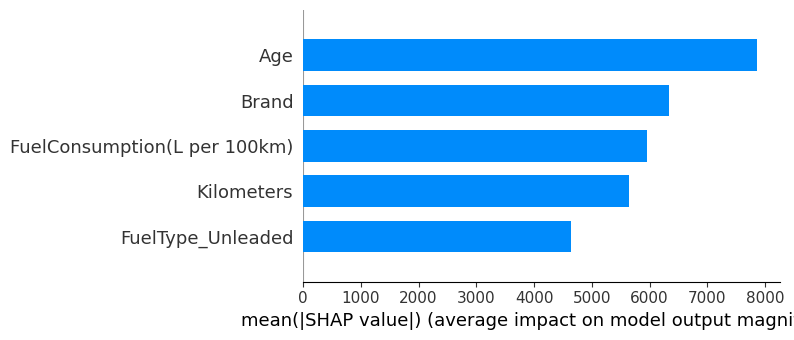

In [53]:
#Feature Importance of best model using SHAP
best_model = xgb
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
labels = X.columns
#Show top 5 features
shap.summary_plot(shap_values, X_test, feature_names=labels, plot_type='bar', max_display=5)

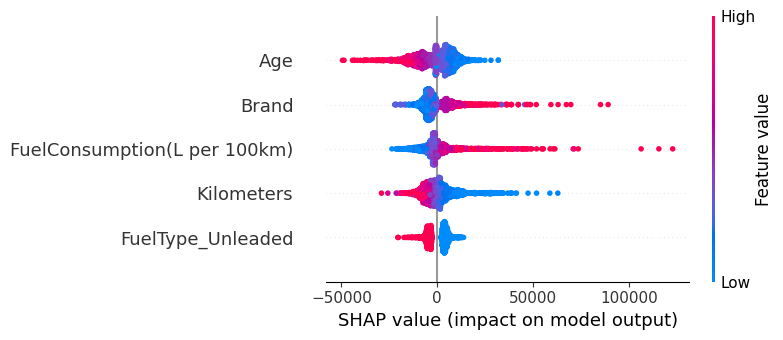

In [54]:
shap.summary_plot(shap_values, X_test, feature_names=labels, max_display=5)

In [55]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=labels)